Welcome to the Topic Modelling Notebook. Here we will see together Topic Modelling argument using 800,000 article titles.
This notebook is written in Python3 and needs the following libraries:

* gensim _(pip install --upgrade gensim)_
* tqdm _(pip install tqdm)_
* puLDAvis _(pip install pyLDAvis)_

_Notice : If you use a version older than Python3.6 you may get some problems using fstrings or function type declarations._

In [5]:
import warnings
warnings.filterwarnings('ignore')
import multiprocessing
import gensim
from gensim import corpora as corporalib
from gensim import models 
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import preprocess_string
import pyLDAvis.gensim 
import csv
import preprocessor as p
import re
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

As usual, we set some initial parametrs in this part:

In [6]:
file_path="Datasets/dblp.xmlarticles.csv"
numcpu = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = (12,6)

The next three functions are not a big deal! they just get data, clean it and prepare it for more serious functions, Topic Modeling fellas!

In [7]:
def get_data(file_path:str): 
    """
    get data from csv file and write them to a csv file
    [is used inside the prepare_LDA_topics() fucntion]
    ---------------------------------------------------
    Parameters:
    file_path : path of the csv file - the file is expected to have two columns with the target data in the second column
    """
    with open(file_path) as f:
        reader = csv.reader(f ,delimiter=";")
        docs = []
        for row in reader:
            if len(row[0])>0:
                docs.append(row[1]) 
        return docs

In [8]:
def text_preprocess(texts:list, limit:int=5000):
    """
    Perform selected pre-processing steps on the given string
    [is used inside the prepare_LDA_topics() fucntion]
    ---------------------------------------------------------
    Parameters:
    text: A string
    limit: the number of lines you want to extract.
    """
    #remove urls
    texts = [re.sub("https?\.+", "", line) for line in texts]
    
    my_filter = [
    lambda x: x.lower(),
    gensim.parsing.strip_punctuation,
    gensim.parsing.strip_multiple_whitespaces,
    gensim.parsing.strip_numeric,
    gensim.parsing.remove_stopwords,
    gensim.parsing.strip_short, 
    gensim.parsing.strip_tags,
    #gensim.parsing.stem_text
    ]
    texts = [preprocess_string(x, filters=my_filter) for x in tqdm(texts[0:limit])]
    
    return texts

<>:11: DeprecationWarning: invalid escape sequence \.
<>:11: DeprecationWarning: invalid escape sequence \.
<>:11: DeprecationWarning: invalid escape sequence \.
<ipython-input-8-99664ccb009a>:11: DeprecationWarning: invalid escape sequence \.
  texts = [re.sub("https?\.+", "", line) for line in texts]


In [9]:
def dict_document_matrix(processed_docs):
    """
    return dictionary and BOW of documents
    [is used inside the prepare_LDA_topics() fucntion]
    --------------------------------------
    Parameters: 
    processed_docs : A list of pre-processed data ,output of text_preprocess() function 
    """
    bigram = gensim.models.Phrases(processed_docs, min_count=5, threshold=0.1) #try increasing min_count to three!!
    trigram = gensim.models.Phrases(bigram[processed_docs], min_count=5, threshold=0.1)
    corpora = [trigram[bigram[s]] for s in processed_docs]
    dictionary = corporalib.Dictionary(corpora)
    documents = [dictionary.doc2bow(corpus) for corpus in corpora] # BoW representation of document
    return dictionary, documents

## Latent Dirichlet Allocation (LDA)

_Before starting with cool stuff, I should mention that the current way to write functions is just used, just to make them more comprehensible for the guys who are just started to learn Python. While the better way (correct way if I may?) is to use OOP and define a class, in order to avoid classes in order to make them more understandable. so please ignore the repetitive and cumbersome lines of code :)_

__LDA or Latent Dirichlet Allocation__ is one of the mostly used models for topic modelling which also has applications beyond extracting topics but also in image processing and Sentiment Analysis. Unlike BOW models, LDA doesn't just consider the frequency of the words but following a more holistic approach it takes into consideration the distribution of words across various topics.
LDA can be a bit complicated if we want to approach it using the _plate notation_:
<img src="Files/plate_notation.png" height="200" width="500">

It has a rather simple concept. To understand it the very first thing we need to understand is that LDA is a generative model. It means unlike discriminative models which learn a function to transform input to output, it tries to determine how the input has been made and using this knowledge it tries to get to the output. So, let's take a look at the assumption LDA makes about documents:

__Assumption:__
Each document has been created in the following way:
* Define the number of words in a document
* Define $K$ topics and their distribution ( Ex. $K=3$ --> 45% topic $A$, 20% topic $B$ and 35% topic $C$)
* Generate words for the document using the distributoin of multinomial distribution of topics in the document and multinomial distribution of words in a topic.

Having such an assumption, in order to assign words to $K$ (defined by you) topics, it follows an algorithm more or less similar to this:
* Randomly assign each word in each document to one of the $K$ topics
* Pick a word and assume that except the specific topic assigned to this word, the other topics assigned to other words are correct.
* Calculate these two probabilities:
 * Probability of having such a topic for target word given the other words in the document $p(topic\mid document)$
 * Probability of having such a word given the distribution of topic in the other documents $p(word \mid topic)$
* Multiple the probabilities calculated above and based on the new probability assign another topic to the word

$$p(topic\mid document) * p(word \mid topic)$$

* Continue this procedure until getting to a stable situation (when assignments make sense)

<img src="Files/LDA_2.png" height="500" width="500">


In [10]:
def prepare_LDA_topics(file_path, num_topics:int=5):
    """
    return the LDA model and other intermediary objects
    ---------------------------------------------------
    Parameters:
    file_path : path of the csv file
    num_topics : number of topics
    """
    docs = get_data(file_path)
    sentences = text_preprocess(docs)
    dictionary, documents = dict_document_matrix(sentences)
    ldamodel = gensim.models.LdaMulticore(documents, num_topics=num_topics, id2word=dictionary, passes=100, workers=numcpu)
    ldatopics = ldamodel.show_topics(formatted=False)
    
    return ldamodel, documents, dictionary, ldatopics

Now that we have defined our function to create a LDA model, let's actially use it!

## Visualization of LDA Topics

In [7]:
LDA_topics = prepare_LDA_topics(file_path)
pyLDAvis.enable_notebook()

# pyLDAvis.gensim.prepare function gets these arguments:
# topic_model : gensim.models.ldamodel.LdaModel :  An already trained Gensim LdaModel.
# corpus : array-like list of bag of word docs in tuple form or scipy CSC matrix. 
# dictionary: gensim.corpora.Dictionary. The dictionary object used to create the corpus. Needed to extract the actual terms (not ids).

pyLDAvis.gensim.prepare(*LDA_topics[:3])

100%|██████████| 5000/5000 [00:00<00:00, 32578.38it/s]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.139697 -0.001018       1        1  23.631550
0      0.006534 -0.006280       2        1  20.694832
4      0.006282  0.114910       3        1  20.275492
1      0.021233 -0.124931       4        1  18.080149
3      0.105648  0.017318       5        1  17.317980, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
252   Default  142.000000            data  142.000000  30.0000  30.0000
74    Default  193.000000         systems  193.000000  29.0000  29.0000
129   Default   47.000000             web   47.000000  28.0000  28.0000
276   Default  117.000000       algorithm  117.000000  27.0000  27.0000
68    Default   83.000000         problem   83.000000  26.0000  26.0000
280   Default   47.000000         channel   47.000000  25.0000  25.0000
385   Default   49.000000          linear   49.000000  24.0000  24.0000
1145  Default   71.000000           fuzzy   71.000000  23.0000  23.0000
97    Default  322.000000           based  322.000000  22.0000  22.0000
805   Default   26.000000    introduction   26.000000  21.0000  21.0000
427   Default   58.000000     distributed   58.000000  20.0000  20.0000
23    Default  212.000000        analysis  212.000000  19.0000  19.0000
254   Default   20.000000         sensing   20.000000  18.0000  18.0000
571   Default   26.000000      properties   26.000000  17.0000  17.0000
651   Default   66.000000         dynamic   66.000000  16.0000  16.0000
258   Default   24.000000       editorial   24.000000  15.0000  15.0000
424   Default   19.000000       sequences   19.000000  14.0000  14.0000
217   Default   19.000000         complex   19.000000  13.0000  13.0000
623   Default   60.000000    optimization   60.000000  12.0000  12.0000
69    Default  104.000000         control  104.000000  11.0000  11.0000
1455  Default   35.000000             use   35.000000  10.0000  10.0000
324   Default   43.000000        wireless   43.000000   9.0000   9.0000
521   Default   34.000000       selection   34.000000   8.0000   8.0000
761   Default   27.000000        protocol   27.000000   7.0000   7.0000
909   Default   16.000000        programs   16.000000   6.0000   6.0000
56    Default   29.000000        language   29.000000   5.0000   5.0000
871   Default   19.000000         objects   19.000000   4.0000   4.0000
171   Default   34.000000         routing   34.000000   3.0000   3.0000
375   Default   16.000000     compression   16.000000   2.0000   2.0000
47    Default   41.000000          theory   41.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
591    Topic5   14.169184           space   27.234396   1.1000  -6.0420
315    Topic5   15.126435           order   31.868843   1.0082  -5.9766
196    Topic5    9.652489            grid   16.836063   1.1971  -6.4258
23     Topic5   56.453117        analysis  212.364960   0.4285  -4.6596
194    Topic5   32.956043          method  106.829453   0.5774  -5.1979
192    Topic5   16.196039          images   38.341927   0.8916  -5.9083
647    Topic5   13.261057            sets   28.715826   0.9808  -6.1082
763    Topic5   14.389239         service   32.883968   0.9269  -6.0266
293    Topic5   16.603750            high   43.346352   0.7938  -5.8834
3      Topic5   14.865679        improved   36.054321   0.8675  -5.9940
531    Topic5   14.801194        software   36.893856   0.8401  -5.9983
146    Topic5   11.011962         minimum   23.228569   1.0070  -6.2941
71     Topic5    9.676332            mode   18.403059   1.1106  -6.4234
89     Topic5   14.913515      simulation   45.895348   0.6293  -5.9908
652    Topic5   10.161755        spectrum   20.879086   1.0333  -6.3744
99     Topic5   10.384226        function   22.510475   0.9797  -6.3528
130    Topic5   13.456652  classification   40.8035

In the visualization above $\lambda$ determines the weight given to the probability of term $w$ under topic $k$ relative to its lift (how prevalence of a term across all topics). 
Setting  $\lambda= 1$ results in the familiar ranking of terms in decreasing order of their topic-specific probability, and setting  $\lambda= 0$ ranks terms solely by their lift. We wish to learn an “optimal” value of  for topic interpretation from our user study.
$$r(w,k\mid \lambda) = \lambda \log(\Phi_{kw})+(1-\lambda)log(\frac{\Phi_{kw}}{P_w})$$

$ \Phi_{kw}$ : probability of term $w \in \left \{ 1, ..., V \right \} $ for topic $k \in \left \{ 1, ..., K\right \}$, where $V$ denotes the number of terms in the vocabulary

$P_w$ : marginal probability of term $w$ in the corpus.

## Latent Semantic Indexing (LSI)

LSI or (LSA, Latent Semantic Analysis)- which is a bit younger model respect to LDA -  uses a linear algebra technique called SVD (singular value decomposition together with BOW representation of text documents for extracting words with similar meanings. LSI is able to model synonymy (multiple words with the same meaning) and polysemy(one word with multiple meaning).
Unlike LDA, LSI is not a generative model, that's why according to some researchers, LSI is a imensionality-reduction technique and not a topic model _(don't feel bad about LSI, there is a probabilistic version of it called pLSI which IS a topic model :D )_
In a nutshell, LSI first uses TF-IDF to create a BOW representation on the documents and then applying SVD technique, tries to convert a big and sparse outcome of TF-IDF to a denser and smaller representaion.

_if you want a numerical walk-though of LSI check [this source](http://www1.se.cuhk.edu.hk/~seem5680/lecture/LSI-Eg.pdf)_

## Hierarchical Dirichlet process (HDP)

hierarchical Dirichlet process ([HDP](https://people.eecs.berkeley.edu/~jordan/papers/hdp.pdf)) is a non-parametric Bayesian model which is similar to LDA _(FYI: D.Blei one of the co-authors of LDA is also a co-author of HDP too)_, considers topics as a mixture of words but unlike LDA, doesn't need to have number of topics a priori but it finds the number of topics as a part of it generative model. (In fact, the "Hierarchical" term is related to finding the number of topics).

_if you're interested to know more about HDP, take a look at this (a bit old) [video](https://www.youtube.com/watch?v=PxgW3lOrj60) from GoogleTechTalks by M.Jordan one the authors of HDP)_

In [8]:
def LSI_HDP_topics(file_path:str, model:str='LSI', topic_n:int=10, word_n:int=10, gettopics:bool=False):
    """
    print topics from Latent Semantic Indexing (LSI) and  Hierarchical Dirichlet process (HDP) models
    -----------------------------
    Parameters:
    file_path : path of the csv file
    model : 'LSI' or 'HDP' (string)
    topic_n : number of topics to be returned (only for LSI)
    word_n : number of keys to be returned for each topic
    gettopics : if true the output won't be printed instead a list o topics will be returned
    """
    docs = get_data(file_path)
    sentences = text_preprocess(docs)
    dictionary, documents = dict_document_matrix(sentences)
    
    
    if model == 'LSI':
        lsimodel = gensim.models.LsiModel(documents, num_topics=topic_n, id2word=dictionary)
        lsitopics = lsimodel.show_topics(formatted=False, num_words=word_n)
        if not gettopics:
            print(f'\033[5m{model} TOPICS\n==========\n')
            for i, t in enumerate(lsitopics):
                print(f'TOPIC {i+1} :')
                tt = t[1]
                ii=1
                end = ' - '
                for couple in tt:
                    if ii == 10:
                        end = '\n'
                    print(couple[0], end=end)
                    ii+=1
                print('-'*100)
        else:
            return lsitopics
                
    elif model == 'HDP':
        hdpmodel = gensim.models.HdpModel(documents, id2word=dictionary) #no numtopic provided
        hdptopics = hdpmodel.show_topics(formatted=False)
        if not gettopics:
            if topic_n > len(hdptopics):
                topic_n = len(hdptopics)
            print(f'\033[5m{model} TOPICS\n==========\n')
            print(f'\033[34m\033[1m{len(hdptopics)}\033[0m topics have been identified. showing the first\033[34m\033[1m {topic_n}\033[0m topics...\n')
            for i, t in enumerate(hdptopics[:topic_n]):
                print(f'\033[1mTOPIC {i+1} :\033[0m')
                tt = t[1]
                ii=1
                end = ' - '
                for couple in tt[:word_n]:
                    if ii == word_n:
                        end = '\n'
                    print(couple[0], end=end)
                    ii+=1
                print('-'*120)
        else:
            return hdptopics

In [9]:
LSI_HDP_topics(file_path, model='HDP')

100%|██████████| 5000/5000 [00:00<00:00, 34915.00it/s]
/Users/navid/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


HDP TOPICS

20 has been identified. showing the first 10 topics...

TOPIC 1 :
wissensmanagement - summarization - resolution - individual - infinis - new - janet - analysis - foundations - edge
----------------------------------------------------------------------------------------------------
TOPIC 2 :
heuristic - individuals - gmres - bucket - bioeconomic - topic - image - fpga - transaction - asymmetry
----------------------------------------------------------------------------------------------------
TOPIC 3 :
boppard - swift - vascular - eye - result - healthy - wiki - subgraph - newfoundland - insights
----------------------------------------------------------------------------------------------------
TOPIC 4 :
handoff - supported - sprite - renvoise - harmonic - antitag - modulated - departures - prng - techniques
----------------------------------------------------------------------------------------------------
TOPIC 5 :
strength - spiral - ligand - rigid - declining - jeremy 

## Evaluation of topics 

Until now, we've seen together three models for extracting topics from texts but how we can evaluate the results we got?
of course, one way would be to perform a qualitative assessment which a part from its dubious outcome, will be quite hard to be done on large datasets.
Another way (let's say the better way) is to do a quantitative analysis. sounds good, right? sure but how can we can make sure that our quantitave method actually represents a human judgement about the extracted topics?

### Topic Coherence

Topic coherence is a quantitative metric which is widely used for evaluation of Topic Modelling algorithms and has two main subgroups:
* Intrinsic Measures (_UMass, ..._)
* Extrinsic Measures (_UCI, ..._)
Despite their slight difference, they both calculate the coherence among the topic words in the same way:

$$Coherence=\sum_{i< j}score(w_i,w_j)$$

Both compute the sum of pairwise scores on the words $w_1$, ..., $w_n$ used to describe the topic, usually the top _n_ words by frequency.
<img src="Files/coherence.png" height="300" width="300">

#### UMass Measure

UMass measures how much, within the words used to describe a topic, a common word is in average a good predictor for a less common word.

As the pairwise score used by the UMass measure is not symmetric, the order of the arguments matters. UMass measure is computing $p(rare\,word \mid common\,word)$, how much a common word triggers a rarer word. 
$$score_{UMass}(w_i, w_j) = log\frac{D(w_i,w_j)+1}{D(w_i)}$$

#### UCI Measure

UCI Measure uses PMI (Pointwise Mutual Information) as pairwise score function:
$$score_{UCI}(w_i, w_j) = log\frac{p(w_i,w_j)+1}{p(w_i)p(w_j)}$$

$p(w)$ represents the probability of seeing $w_i$ in a random document, and $p(w_i,w_j)$ the probability of seeing both $w_i$ and $w_j$ co-occurring in a random document. UCI authors have calculated this values using Wikipedia dataset as the random document and as a result UCI induces orderings from bad to good topics that come closest to human coherence judgements.

$$p(w_i,w_j) = \frac{D_{wikipedia}(w_i, w_j)}{D_{wikipedia}}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,and\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,p(w_i) = \frac{D_{wikipedia}(w_i)}{D_{wikipedia}}$$ 


__$C_v$__

$C_v$ is a extrinsic measure introduced by _Roder et al._ in their important paper _Exploring the Space of Topic Coherence Measures_. $C_v$ is a combination of indirect Cosine measure, Normalized PMI and Boolean Sliding Window method (which makes it close to UCI Metric.

Ok, Let's create a function for plotting the coherence results:

In [24]:
def evaluate_graph(file_path:str, limit:int=4, num_topics:int=10, metric='c_v'):
    """
    return a LDA graph using c_v coherence
    --------------------------------------------------------------
    Parameters:
    file_path : path of the csv file
    limit : topic limit
    num_topics : number of topics to be returned
    metric : metric to be used to measure the coherency. can be ['c_v', 'u_mass']
    """
    docs = get_data(file_path)
    sentences = text_preprocess(docs)
    dictionary, documents = dict_document_matrix(sentences)
    metric_list = []
    lm_list = []
    for num_topics in tqdm(range(1, limit+1)):
        lm = gensim.models.LdaMulticore(corpus=documents, passes=30, num_topics=num_topics, id2word=dictionary, workers=numcpu)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=sentences, dictionary=dictionary, coherence=metric)
        metric_list.append(cm.get_coherence())
    
    x = range(1, limit+1)
    plt.plot(x, metric_list)
    plt.scatter(x, metric_list, s=40, color='r')
    plt.title('Coherence Measure Evaluation', fontsize=22)
    plt.xlabel("Number of topics")
    plt.ylabel("Coherence score")
    plt.xticks(list(range(1, limit+1)))
    plt.show()


100%|██████████| 3/3 [01:11<00:00, 21.01s/it]


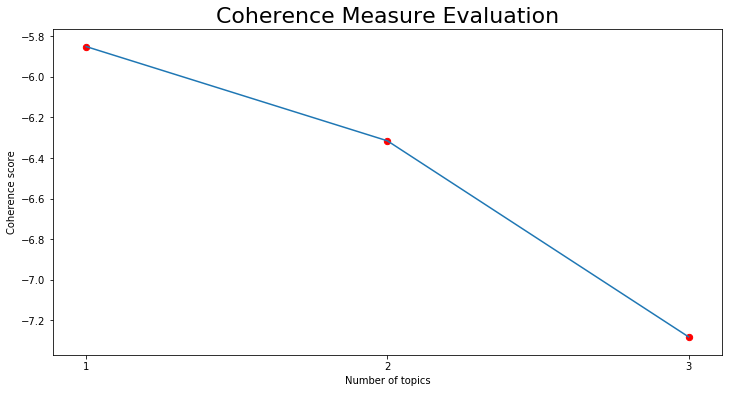

In [27]:
evaluate_graph(file_path, limit=6, metric='c_v')

The above function plots the coherence for differewnt topic numbers of one model byt what if we want to comoare different models together? 

In [ ]:
def evaluate_bar_graph(file_path:str, indices:list, log:bool=True):
    """
    plot a coherences bar chart for the given model(s)
    --------------------------------------------------
    parametrs:
    file_path : path of the csv file
    indices : Indices to be used to mark bars. Length of this and coherences should be equal. (only the first 10 topic are used)
    log : if True the status of the process will be printed out
    """
    docs = get_data(file_path)
    sentences = text_preprocess(docs)
    dictionary, documents = dict_document_matrix(sentences)
    coherences = []
    for ind in indices:
        if log:
            print(f'\33[34mCreating {ind} model ...')
        if ind == 'LSI':
            lsitopics = LSI_HDP_topics(file_path, model='LSI', gettopics=True)
            lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]
            lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=sentences, dictionary=dictionary, window_size=10).get_coherence()
            coherences.append(lsi_coherence)
        elif ind == 'HDP':
            hdptopics = LSI_HDP_topics(file_path, model='HDP', gettopics=True)
            hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]
            hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=sentences, dictionary=dictionary, window_size=10).get_coherence()
            coherences.append(hdp_coherence)
        elif ind == 'LDA':
            ldatopics = prepare_LDA_topics(file_path, )[3]
            ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]
            lda_coherence = CoherenceModel(topics=ldatopics, texts=sentences, dictionary=dictionary, window_size=10).get_coherence()
            coherences.append(lda_coherence)
        
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.title('Coherence Comparison', fontsize=20 )
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    plt.show()

100%|██████████| 5000/5000 [00:00<00:00, 35170.89it/s]


Creating LSI model ...


100%|██████████| 5000/5000 [00:00<00:00, 27897.71it/s]


Creating HDP model ...


100%|██████████| 5000/5000 [00:00<00:00, 27437.71it/s]
/Users/navid/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


Creating LDA model ...


100%|██████████| 5000/5000 [00:00<00:00, 16888.14it/s]


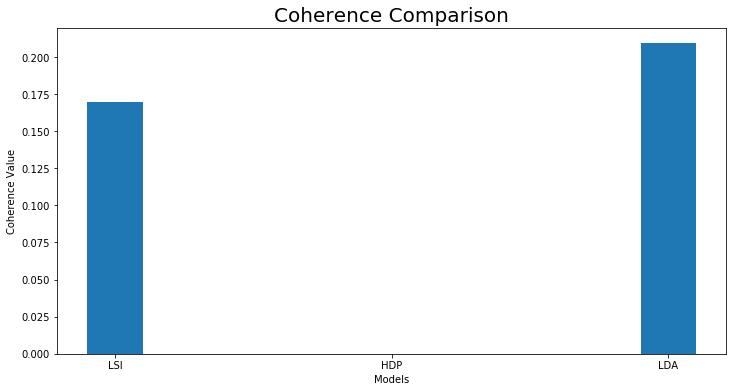

In [13]:
evaluate_bar_graph(file_path, ['LSI', 'HDP', 'LDA'])

## Resources

Leveraging Unstructured Information Using Topic Modelling [link](http://induvations.co.za/attachments/146_Leveraging%20Unstructured%20Information%20Using%20Topic%20Modelling.pdf)

LDAvis: A method for visualizing and interpreting topics [link](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)

Exploring the Space of Topic Coherence Measures [link](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

Evaluating topic coherence measures [link](https://arxiv.org/pdf/1403.6397.pdf)